# 4.0 Model Experimentation

[![Static Badge](https://img.shields.io/badge/Back_to_README.md-red?style=for-the-badge&logo=github&labelColor=black)](https://github.com/izzad2413/sustainable_ota)

### Table of Contents

- 4.1 Dataset Preparation
- 4.2 Model Development
- 4.3 Model Experimentation
- 4.4 Model Evaluation
- 4.5 Finalising the Model
- 4.6 Conclusion

In [1]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
model_data_dir = './../data/modeling/modeling_data.csv' # dataset directory
df = pd.read_csv(model_data_dir)

### 4.1 Dataset Preparation

Based on the 3.0 feature selection experiment, it was decided that the selected 22 features will be used for model building.

In [3]:
df = df[['quality_rating', 'preferred_partner', 'count_room_types',
       'overall_reviews', 'count_reviews', 'count_topattractions',
       'count_closestairports', 'count_groups of friends',
       'lan_eng_proportion', 'lan_malay_proportion',
       'average_all_closestairports_distances', 'bathroom',
       'business_facilities', 'common_areas', 'languages_spoken',
       'living_area', 'miscellaneous', 'outdoors', 'reception_services',
       'safety_&_security', 'services_&_extras', 'swimming_pool','sustainable_label']]

### 4.2 Model Development

The exprimented classifiers with its respective parameter & values.

In [4]:
all_features = [
    'quality_rating', 'preferred_partner', 'count_room_types', 'overall_reviews',
    'count_reviews', 'count_topattractions', 'count_closestairports', 'lan_eng_proportion',
    'lan_malay_proportion', 'average_all_closestairports_distances', 'bathroom',
    'business_facilities', 'common_areas', 'languages_spoken', 'living_area', 
    'miscellaneous', 'outdoors', 'reception_services', 'safety_&_security', 
    'services_&_extras', 'swimming_pool'
]

# Function to generate feature sets
def generate_feature_sets(all_features, min_features=11, max_features=22):
    feature_sets = {}
    for num_features in range(min_features, max_features + 1):
        feature_set_name = f'f_{num_features}'
        feature_sets[feature_set_name] = df[all_features[:num_features]]
    return feature_sets

# Generate feature sets
feature_sets = generate_feature_sets(all_features)

# Define classifiers and their parameter grids
# Using best values that has been tested on 22 features
classifiers_param_grid = {
    'SVM': {
        'model': SVC(),
        'param_grid': {
            'classifier__C': [0.1],
            'classifier__gamma': [0.001],
            'classifier__kernel': ['poly']
        }
    },
    'RF': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [200],
            'classifier__max_depth': [None],
            'classifier__min_samples_split': [10],
            'classifier__min_samples_leaf': [1],
            'classifier__bootstrap': [False]
        }
    },
    'DT': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__max_depth': [10],
            'classifier__min_samples_split': [2],
            'classifier__min_samples_leaf': [4],
            'classifier__criterion': ['entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'classifier__n_neighbors': [9],
            'classifier__weights': ['distance'],
            'classifier__algorithm': ['auto'],
            'classifier__p': [1]
        }
    },
    'MLP': {
        'model': MLPClassifier(),
        'param_grid': {
            'classifier__hidden_layer_sizes': [(100,)],
            'classifier__activation': ['logistic'],
            'classifier__solver': ['adam'],
            'classifier__alpha': [0.001],
            'classifier__learning_rate': ['constant'],
            'classifier__max_iter': [200],
            'classifier__early_stopping': [True],
            'classifier__validation_fraction': [0.1],
            'classifier__n_iter_no_change': [5],
            'classifier__random_state': [42] 
            
        }
    }
}

def classifier_grid_search(X_train, y_train, X_test, y_test, model, param_grid, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=5):
    # to prevent data leakage
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    cv_strategy = RepeatedStratifiedKFold(n_splits=cv, n_repeats=2, random_state=42)

    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='precision', cv=cv_strategy)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    best_index = grid_search.best_index_
    mean_scores = {scorer: grid_search.cv_results_[f'mean_test_{scorer}'][best_index] for scorer in scoring}

    y_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_curve, precision_curve)

    test_scores = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'pr_auc': pr_auc
    }

    return grid_search.best_estimator_, best_params, mean_scores, test_scores

### 4.3 Model Experimentation

In [5]:
# Run model experiment
# Target feature
y = df['sustainable_label']

# Collect results for each feature set and classifier
results = []

for feature_set_name, X in feature_sets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    for classifier_name, classifier_info in classifiers_param_grid.items():
        model = classifier_info['model']
        param_grid = classifier_info['param_grid']
        
        best_estimator, best_params, mean_scores, test_scores = classifier_grid_search(X_train, y_train, X_test, y_test, model, param_grid)
        
        result = {
            'feature_set': feature_set_name,
            'classifier': classifier_name,
            'best_params': best_params,
            **{f'val_{score}': score_value for score, score_value in mean_scores.items()},
            **{f'test_{score}': score_value for score, score_value in test_scores.items()}
        }
        results.append(result)

# Convert results to DataFrame for better analysis
results_df = pd.DataFrame(results)

In [6]:
# Saving the result for backup
date_today = datetime.datetime.now().strftime("%d-%m-%Y")
save_dir = f'./../data/result/{date_today}_model-experimentation_result.csv'
results_df.to_csv(save_dir, index=False) 

### 4.4 Model Evaluation

In [7]:
def plot_metrics(results_df, model_chosen):
    # Filter the DataFrame for the chosen model classifier
    df_model = results_df[results_df['classifier'] == model_chosen]
    
    # Define the performance metrics
    metrics = {
        'test_accuracy': 'Accuracy',
        'test_precision': 'Precision',
        'test_recall': 'Recall',
        'test_f1': 'F1-Scores',
        'test_pr_auc': 'Precision Recall AUC Scores'
    }
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot each metric and annotate the maximum value
    for metric, label in metrics.items():
        sns.lineplot(data=df_model, x='feature_set', y=metric, marker='o', linestyle='-', label=label)
        max_value = df_model[metric].max()
        max_index = df_model[metric].idxmax()
        max_feature_set = df_model.loc[max_index, 'feature_set']
        plt.text(max_feature_set, max_value, f'{max_value:.2f}', horizontalalignment='right', verticalalignment='bottom')

    # Customizing the plot
    plt.title(f'{model_chosen} Metrics vs Feature Set')
    plt.xlabel('Feature Set')
    plt.ylabel('Scores')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show plot
    plt.show()

Plot each models' performance on the metrics 

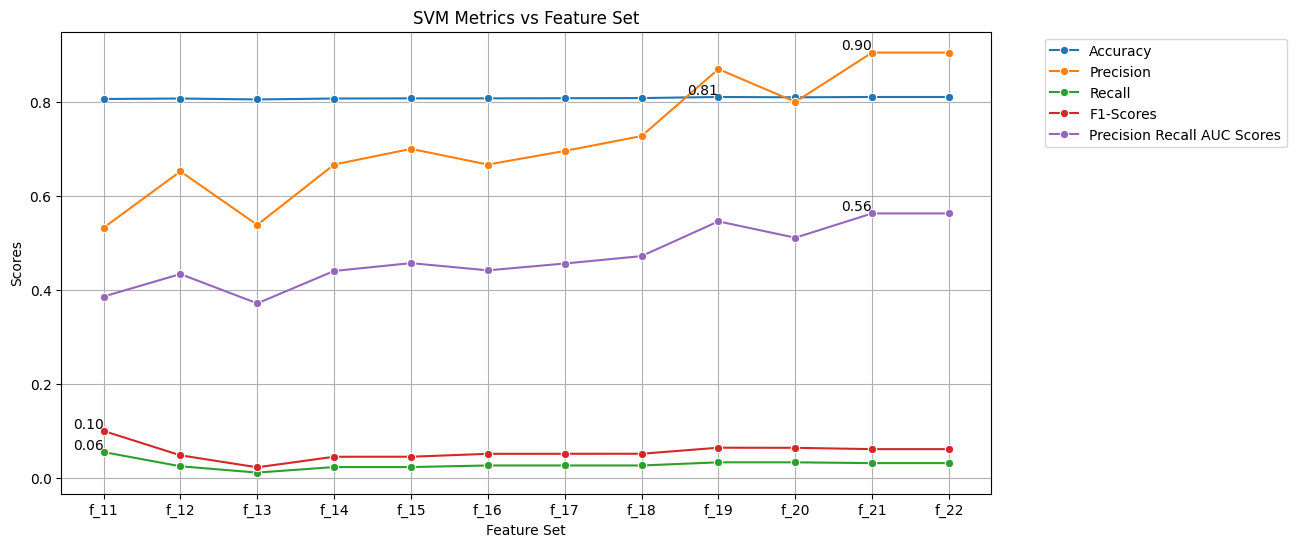

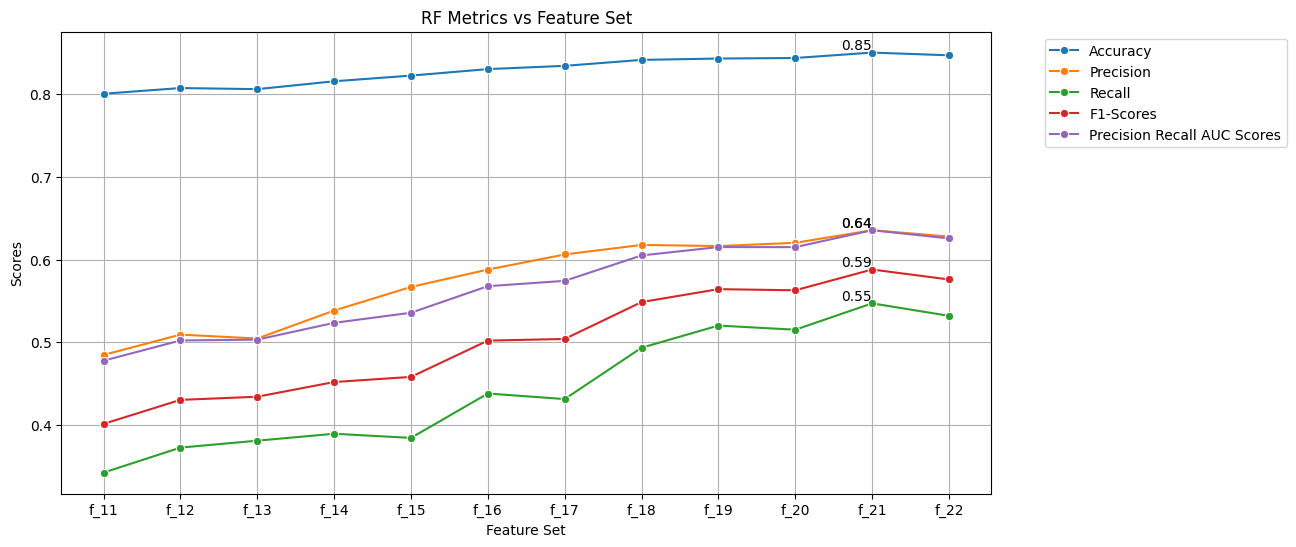

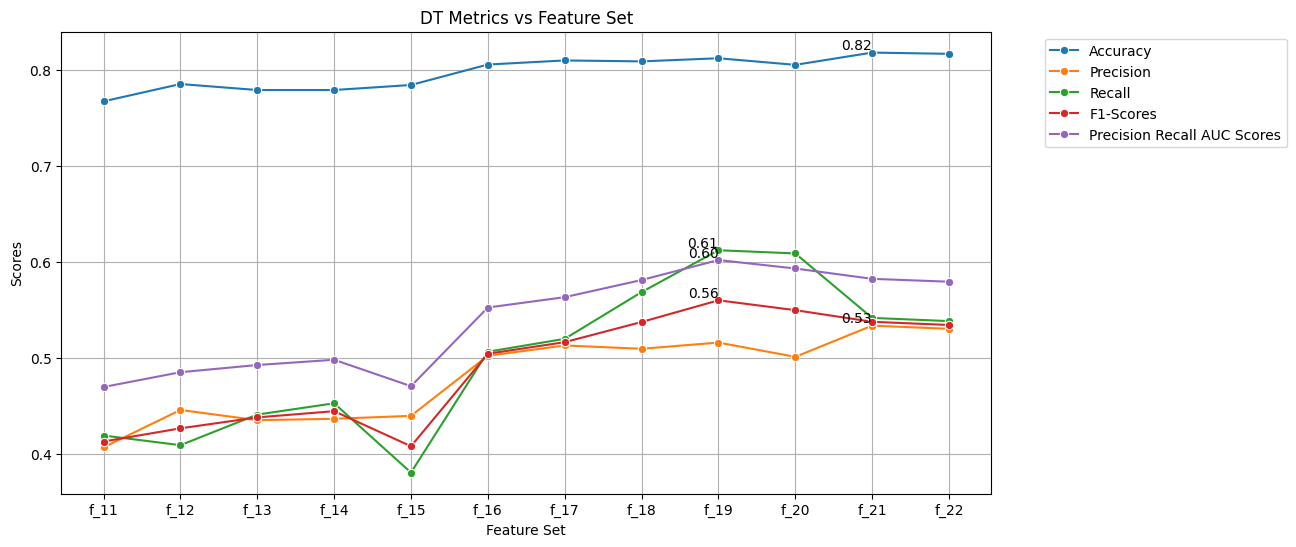

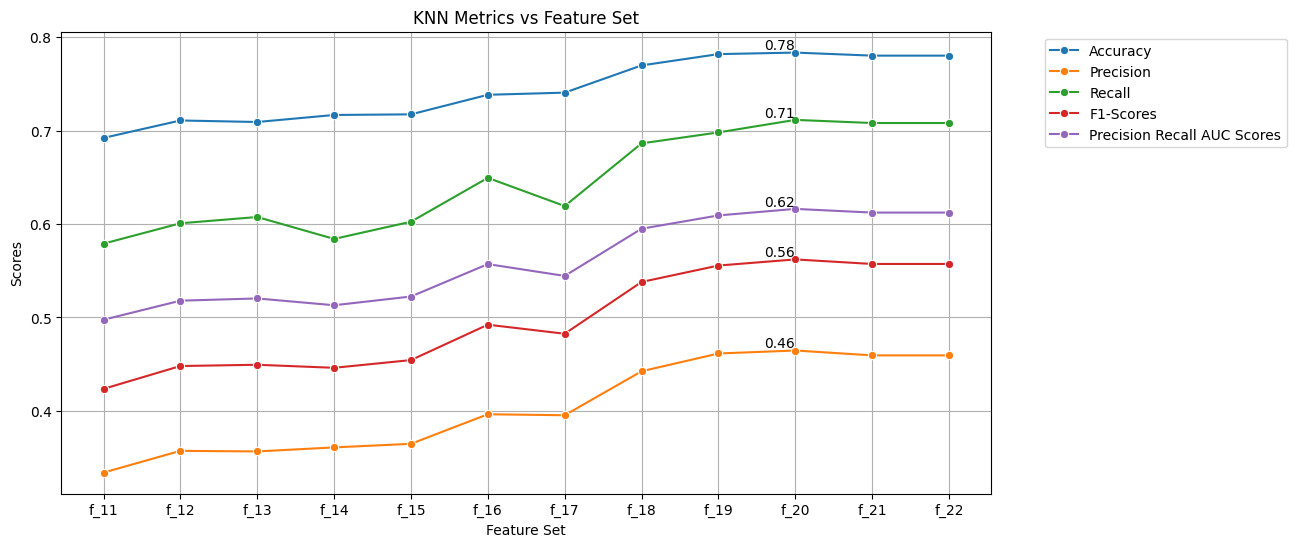

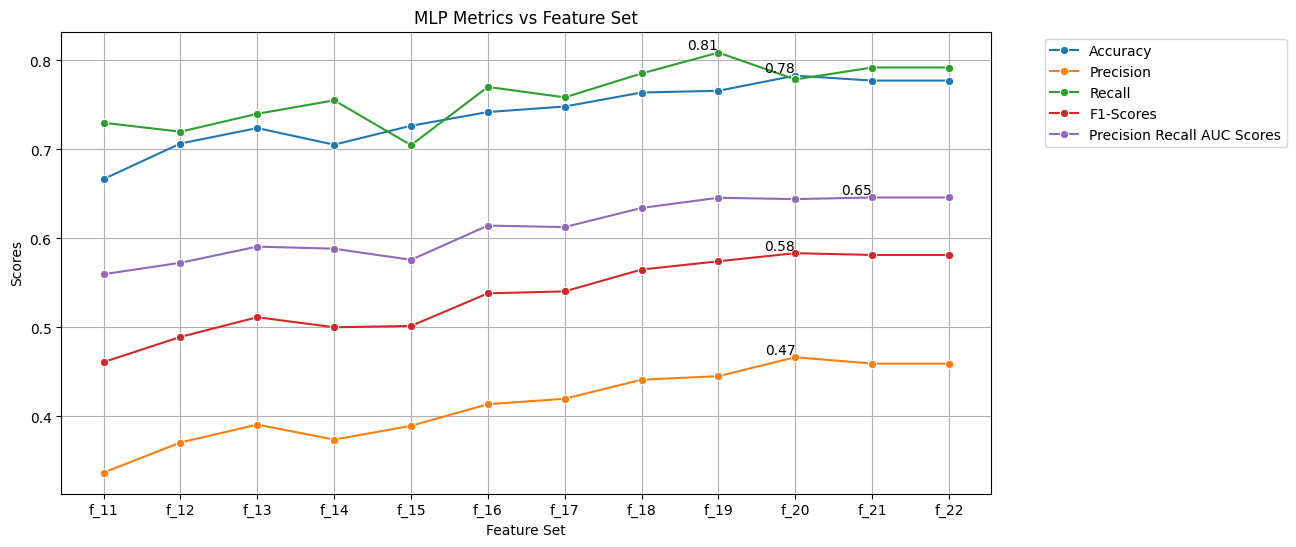

In [8]:
# List of classifiers to plot
classifiers = ['SVM', 'RF', 'DT', 'KNN', 'MLP']

# Plot for each classifier
for classifier in classifiers:
    plot_metrics(results_df, classifier)

The highest scores for each model

| Model | Precision | Accuracy | Precision-Recall AUC | F1 Score | Recall |
|-------|-----------|----------|----------------------|----------|--------|
| SVM   | 0.90       | 0.81     | 0.56                 | 0.10     | 0.06   |
| RF    | 0.64      | 0.85     | 0.64                 | 0.59     | 0.55   |
| DT    | 0.52      | 0.82     | 0.60                 | 0.56     | 0.61   |
| KNN   | 0.46      | 0.78     | 0.62                 | 0.56     | 0.71   |
| MLP   | 0.47      | 0.78     | 0.65                 | 0.58     | 0.81   |


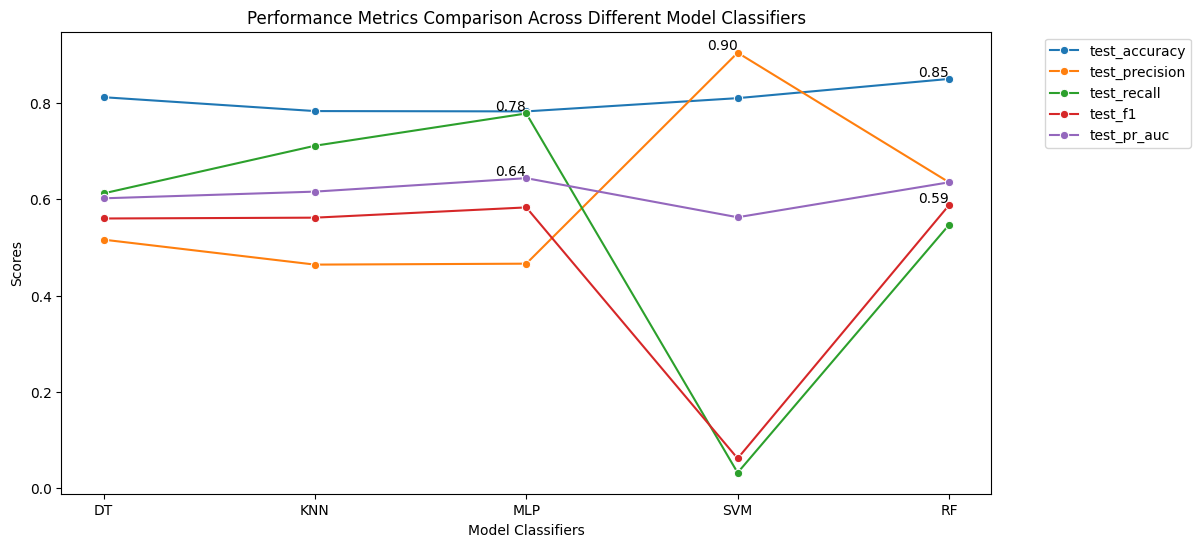

In [9]:
# Get the best model with feature set
# Filter data based on the specified conditions
filtered_df = results_df[
    ((results_df['classifier'] == 'SVM') & (results_df['feature_set'] == 'f_21')) |
    ((results_df['classifier'] == 'RF') & (results_df['feature_set'] == 'f_21')) |
    ((results_df['classifier'] == 'DT') & (results_df['feature_set'] == 'f_19')) |
    ((results_df['classifier'] == 'KNN') & (results_df['feature_set'] == 'f_20')) |
    ((results_df['classifier'] == 'MLP') & (results_df['feature_set'] == 'f_20'))
]

# Define the performance metrics
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_pr_auc']

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a line for each metric and annotate the maximum value
for metric in metrics:
    sns.lineplot(data=filtered_df, x='classifier', y=metric, marker='o', linestyle='-', label=metric)
    max_value = filtered_df[metric].max()
    max_index = filtered_df[metric].idxmax()
    max_model = filtered_df.loc[max_index, 'classifier']
    plt.text(max_model, max_value, f'{max_value:.2f}', horizontalalignment='right', verticalalignment='bottom')

# Set the labels
plt.xlabel('Model Classifiers')
plt.ylabel('Scores')
plt.title('Performance Metrics Comparison Across Different Model Classifiers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Looking at the figures, MLP and RF show good choices for prediction. MLP demonstrates strong performance in recall, PRAUC, and similar F1 scores. Therefore, MLP with a 20-feature set is the chosen model.

### 4.5 Finalising the Model

In [12]:
# chosen model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='logistic',
    solver='adam',
    alpha=0.001,
    learning_rate='constant',
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=42
)

In [13]:
# Function to generate feature sets (specifically set for 20 features in this case)
def generate_feature_set(all_features, num_features):
    selected_features = all_features[:num_features]
    feature_set = df[selected_features]
    return feature_set, selected_features

# Generate the feature set with 20 features
num_features = 20
feature_set, selected_features = generate_feature_set(all_features, num_features)

# Target feature
y = df['sustainable_label']

# Use the feature set with 20 features for training
X = feature_set

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# to prevent data leakage
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', mlp_model)
])

# Train the MLP model
mlp_pipeline.fit(X_train, y_train)

# Evaluate the model (optional)
y_pred = mlp_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Selected features:", selected_features)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Selected features: ['quality_rating', 'preferred_partner', 'count_room_types', 'overall_reviews', 'count_reviews', 'count_topattractions', 'count_closestairports', 'lan_eng_proportion', 'lan_malay_proportion', 'average_all_closestairports_distances', 'bathroom', 'business_facilities', 'common_areas', 'languages_spoken', 'living_area', 'miscellaneous', 'outdoors', 'reception_services', 'safety_&_security', 'services_&_extras']
Accuracy: 0.7828365542089748
Precision: 0.4663316582914573
Recall: 0.7785234899328859
F1 Score: 0.5832809553739786


In [14]:
# Save the trained pipeline to a pickle file
with open('./../models/mlp_pipeline.pkl', 'wb') as file:
    pickle.dump(mlp_pipeline, file)

print("Pipeline saved to 'mlp_pipeline.pkl'")  

Pipeline saved to 'mlp_pipeline.pkl'


### 4.6 Conclusion

- 22 features were tested as a result of feature selection.
- Models were evaluated with feature sets ranging from 11 to 22 features and tested with respective parameters and values.
- Evaluation metrics included accuracy, precision, recall, F1 scores, and PRAUC.
- MLP demonstrated strong performance in recall and PRAUC, with similar F1 scores compared to RF.
- The MLP model will be used for deployment in the web application.